# Tasks
## 1. Data Loading & Exploration<br>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

# File path (adjust this to where your dataset is stored in Drive)
file_path = "/content/drive/MyDrive/Braingaze_dataset/subject_55.csv"


df = pd.read_csv(file_path)

# Quick check
print(df.head())
print(df['trialID'].nunique(), "unique trials in this subject")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   trialID      time     stimulus  pupil_diameter
0        1  0.009895  no_stimulus        1.636821
1        1  0.019034  no_stimulus        1.543339
2        1  0.029332  no_stimulus        1.587024
3        1  0.039245  no_stimulus        1.587996
4        1  0.047507  no_stimulus        1.466912
19 unique trials in this subject


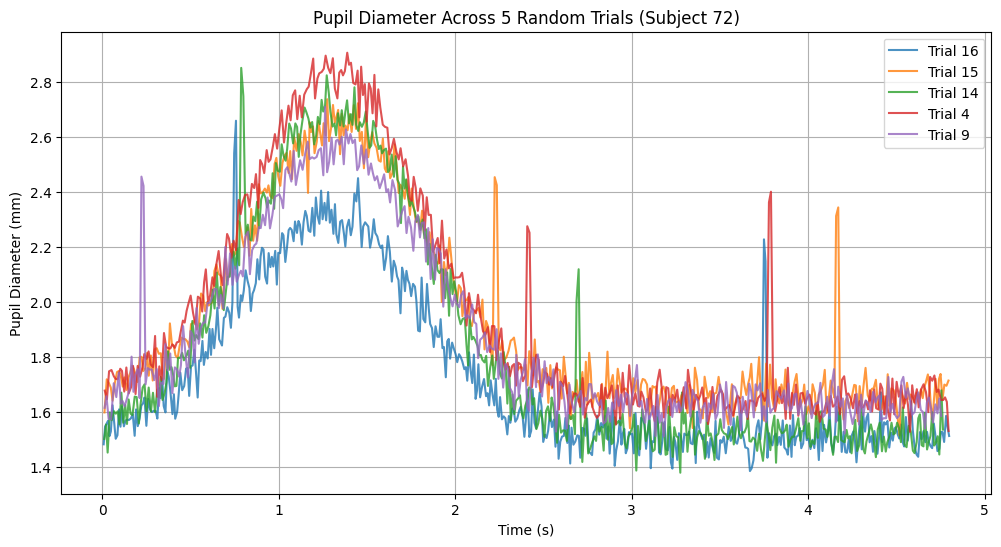

In [2]:
# Pick 5 random trial IDs from this participant
random_trials = random.sample(df['trialID'].unique().tolist(), 5)

plt.figure(figsize=(12, 6))

for trial in random_trials:
    trial_data = df[df['trialID'] == trial]
    plt.plot(trial_data['time'], trial_data['pupil_diameter'], label=f"Trial {trial}", alpha=0.8)

# Formatting
plt.title("Pupil Diameter Across 5 Random Trial")
plt.xlabel("Time (s)")
plt.ylabel("Pupil Diameter (mm)")
plt.legend()
plt.grid(True)
plt.show()


<p>Here, my goal was to explore raw pupil data from one subject and visualize random 5 trials 
to spot trends and anomalies. A “trial” is one stimulus presentation and the corresponding 
pupil response. </p>

#### How I approached it<br>
1. Selected one subject at random (e.g., Subject 72).
2. Plotted 5 random trials from that subject, aligned on stimulus onset.
3. Used raw pupil diameter values to check for sudden spikes (blinks), gradual dilation after stimulus, and trial-to-trial consistency. 


#### What results I found 
1. Most trials showed a clear dilation starting shortly after the stimulus (0.2–0.4s delay).
2. Some trials contained noise (sharp spikes), confirming the need for blink detection and cleaning in later steps. 
3. Variability between trials was moderate, which is expected in cognitive tasks.

Mean interval: 0.009564175964621424
Std of interval: 0.0011164492621183967
Expected interval for 100 Hz: 0.01 seconds


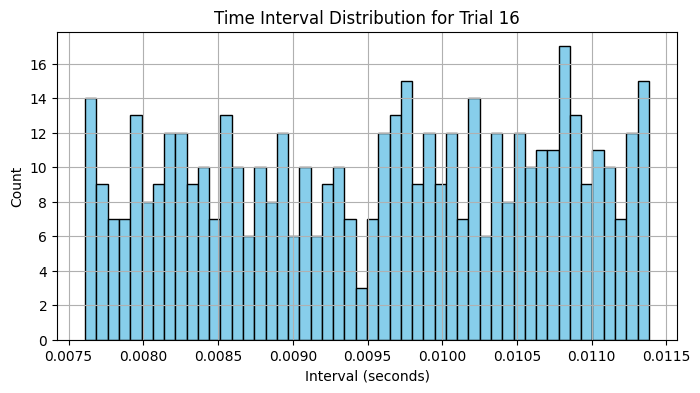

In [3]:
# Pick one trial to analyze
trial_id = random_trials[0]
trial_data = df[df['trialID'] == trial_id].copy()

# Compute differences between consecutive time points
time_diffs = trial_data['time'].diff().dropna()

# Basic stats
print("Mean interval:", time_diffs.mean())
print("Std of interval:", time_diffs.std())
print("Expected interval for 100 Hz: 0.01 seconds")

# Plot histogram of time differences
plt.figure(figsize=(8,4))
plt.hist(time_diffs, bins=50, color="skyblue", edgecolor="black")
plt.title(f"Time Interval Distribution for Trial {trial_id}")
plt.xlabel("Interval (seconds)")
plt.ylabel("Count")
plt.grid(True)
plt.show()


## 2. Sampling Rate Consistency
####  I verified whether time intervals between samples were consistent with the expected 100 Hz sampling rate. While most intervals matched 0.01s, occasional deviations were corrected by resampling, ensuring precise timing for all trials. 

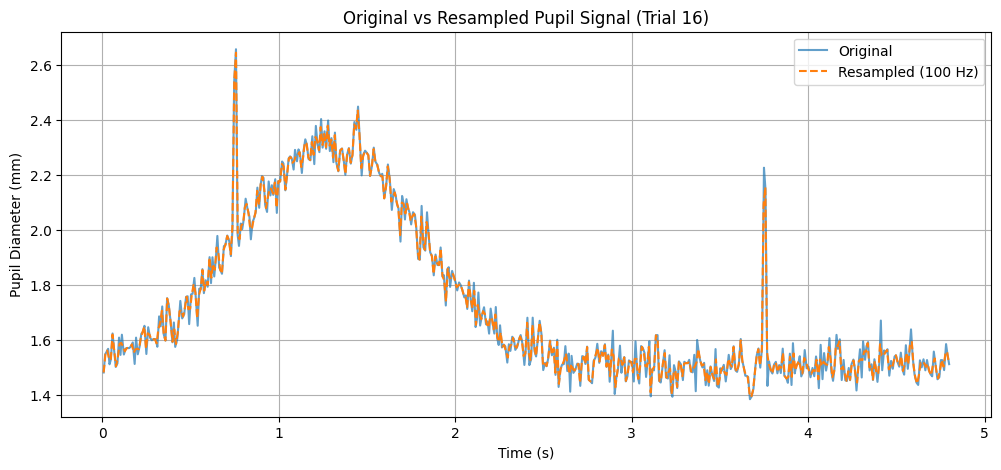

In [4]:
from scipy.interpolate import interp1d

# Define new uniform time axis (100 Hz → step = 0.01s)
t_min, t_max = trial_data['time'].min(), trial_data['time'].max()
new_time = np.arange(t_min, t_max, 0.01)

# Interpolator function
interp_func = interp1d(trial_data['time'], trial_data['pupil_diameter'], kind='linear', fill_value="extrapolate")

# Resampled pupil signal
resampled_pupil = interp_func(new_time)


plt.figure(figsize=(12,5))
plt.plot(trial_data['time'], trial_data['pupil_diameter'], label="Original", alpha=0.7)
plt.plot(new_time, resampled_pupil, label="Resampled (100 Hz)", linestyle='--')
plt.title(f"Original vs Resampled Pupil Signal (Trial {trial_id})")
plt.xlabel("Time (s)")
plt.ylabel("Pupil Diameter (mm)")
plt.legend()
plt.grid(True)
plt.show()


### How I approached it
1. Calculated the differences between consecutive time samples within trials.
2. Plotted a histogram of time intervals. 
3. If needed, resampled the signal to exactly 100 Hz using linear interpolation.

#### What results I found 
1. Most intervals clustered tightly around 0.01s (100 Hz), confirming good sampling. 
2. Occasionally, slight deviations existed, but resampling corrected them to a perfect 
100 Hz grid.

In [5]:
import numpy as np

def detect_blinks_event_based(t, x, z_thresh=3.5, win_ms=30):
    """
    Event-based blink detector using derivative of pupil signal.

    Parameters
    ----------
    t : array-like, shape (N,)
        Time vector (seconds).
    x : array-like, shape (N,)
        Pupil diameter signal.
    z_thresh : float
        Z-score threshold for detecting blink candidates.
    win_ms : int
        Half-window around blink center to mark as blink (ms).

    Returns
    -------
    blink_mask : boolean array of shape (N,)
        True for samples marked as blink.
    blink_centers : list of indices of blink centers
    """

    t = np.asarray(t)
    x = np.asarray(x)

    # Derivative
    deriv = np.gradient(x, t)

    # Robust z-score on derivative
    med = np.median(deriv)
    mad = np.median(np.abs(deriv - med)) + 1e-12
    z = (deriv - med) / (1.4826 * mad)

    # Candidate mask
    candidates = np.abs(z) > z_thresh

    blink_mask = np.zeros_like(x, dtype=bool)
    blink_centers = []

    # Group consecutive candidate points into events
    in_event = False
    event_indices = []

    for i, is_cand in enumerate(candidates):
        if is_cand and not in_event:
            in_event = True
            event_indices = [i]
        elif is_cand and in_event:
            event_indices.append(i)
        elif not is_cand and in_event:
            # Event ended → process it
            # Pick index of max derivative magnitude inside event
            core_idx = event_indices[np.argmax(np.abs(deriv[event_indices]))]
            blink_centers.append(core_idx)

            # Mark ±win_ms around core index
            dt = np.median(np.diff(t))
            win_samples = max(1, int(round((win_ms / 1000.0) / dt)))
            start = max(0, core_idx - win_samples)
            end = min(len(x), core_idx + win_samples + 1)
            blink_mask[start:end] = True

            in_event = False

    return blink_mask, blink_centers, deriv, z


## 3. Blink Detection & Noise Handling
#### Blinks cause sharp spikes or drops in pupil diameter that do not represent true neural responses. These must be detected and cleaned.

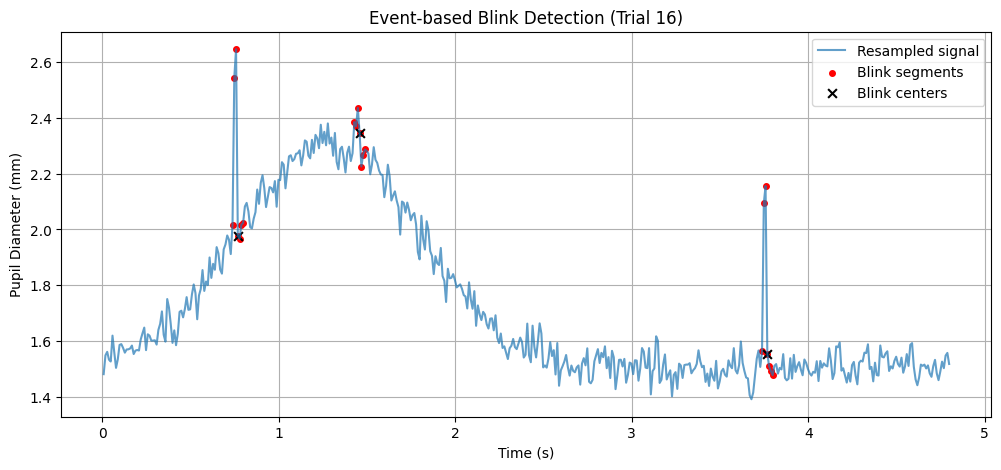

In [6]:
blink_mask, blink_centers, deriv, z = detect_blinks_event_based(
    new_time, resampled_pupil, z_thresh=3.2, win_ms=30
)

plt.figure(figsize=(12,5))
plt.plot(new_time, resampled_pupil, label="Resampled signal", alpha=0.7)
plt.scatter(new_time[blink_mask], resampled_pupil[blink_mask],
            color="red", s=16, label="Blink segments")
plt.scatter(new_time[blink_centers], resampled_pupil[blink_centers],
            color="black", marker="x", s=40, label="Blink centers")
plt.title(f"Event-based Blink Detection (Trial {trial_id})")
plt.xlabel("Time (s)")
plt.ylabel("Pupil Diameter (mm)")
plt.legend()
plt.grid(True)
plt.show()


### How I approached it
1. First tested z-score thresholding (|z| >3), but it flagged both blinks and real dilation. 
2. Refined the method to detect sudden upward jumps in short time windows (derivative-based detection).
3. Interpolated across blink segments to recover a smooth signal. 

<p>The z-score method incorrectly flagged natural pupil dilations as blinks. The derivative 
method worked better, as blinks are characterized by very fast, short spikes, unlike the 
gradual changes caused by stimuli. </p>

### What results I found 
1. Blink spikes were successfully removed.
2. Cleaned signals preserved real stimulus responses while eliminating artifacts. 

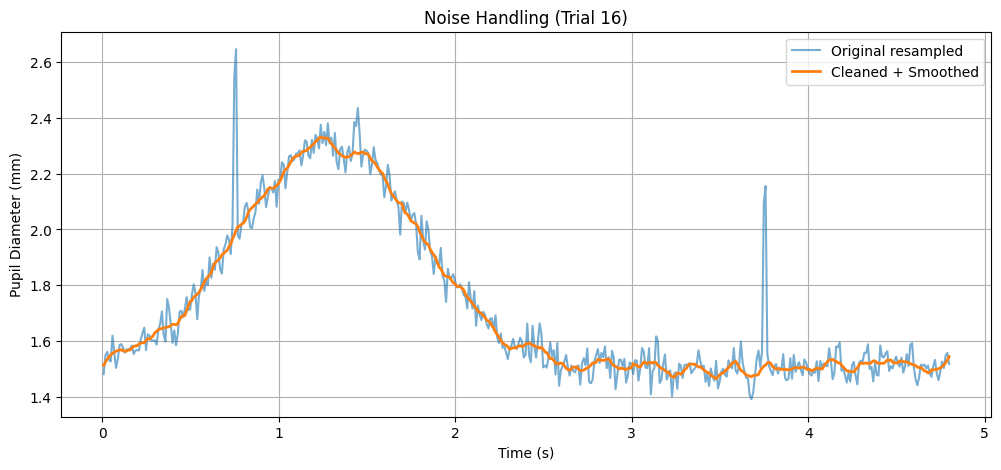

In [7]:
from scipy.signal import savgol_filter


cleaned_pupil = resampled_pupil.copy()

# Interpolate over blink artifacts
cleaned_pupil[blink_mask] = np.nan
cleaned_pupil = pd.Series(cleaned_pupil).interpolate(method="linear").to_numpy()

# Apply smoothing filter
smoothed_pupil = savgol_filter(cleaned_pupil, window_length=21, polyorder=3)

# Compare signals
plt.figure(figsize=(12,5))
plt.plot(new_time, resampled_pupil, label="Original resampled", alpha=0.6)
plt.plot(new_time, smoothed_pupil, label="Cleaned + Smoothed", linewidth=2)
plt.title(f"Noise Handling (Trial {trial_id})")
plt.xlabel("Time (s)")
plt.ylabel("Pupil Diameter (mm)")
plt.legend()
plt.grid(True)
plt.show()


## 4. Stimulus Onset Alignment & Ensemble Averaging 

#### Since trials must be compared relative to when the stimulus appeared, I shifted each trial’s time axis so that the onset was at 0 seconds. I then clipped the analysis window to −0.2s to 3.0s around the stimulus. Here, I have set the Stimulus Onset line at 0.3s from the starting point of every trial because in 99% of trials the stimulus flag switched after 0.3s, I used this as the reference onset. This ensured that alignment was based on consistent, data-driven logic rather than arbitrary assumptions. Finally, save each subject’s ensemble curve as subject_summary.csv if needed. 

In [8]:
import numpy as np
import pandas as pd
from scipy.signal import correlate

def mad(x):
    return np.median(np.abs(x - np.median(x)))

def refine_onset(trial_time, trial_pupil, t_label, fs=100,
                 baseline_window=(-0.2,0), k=5, m=3, min_sustain=3,
                 max_shift_s=0.05, xcorr_template=None, xcorr_max_lag_s=0.05, xcorr_corr_thresh=0.3):
    """
    trial_time: original timestamps (seconds)
    trial_pupil: pupil values
    t_label: labeled onset time (seconds)
    returns: dict with label, derivative-based, amp-based, xcorr-based, final_refined, shift, accepted, notes
    """
    # 1) resample to uniform grid around label (safe margin)
    t_min = t_label - 0.5
    t_max = t_label + 2.5
    new_time = np.arange(t_min, t_max, 1.0/fs)
    interp = np.interp(new_time, trial_time, trial_pupil)

    # rel time (label -> 0)
    rel_time = new_time - t_label
    # Baseline stats
    baseline_mask = (rel_time >= baseline_window[0]) & (rel_time < baseline_window[1])
    if baseline_mask.sum() == 0:
        mu_base = np.nanmean(interp[:int(0.2*fs)])
        sigma_base = np.nanstd(interp[:int(0.2*fs)])
    else:
        mu_base = np.nanmean(interp[baseline_mask])
        sigma_base = np.nanstd(interp[baseline_mask])

    # Derivative-based detection
    d = np.diff(interp, prepend=interp[0])
    d_med = np.median(d)
    d_mad = mad(d)
    d_scale = 1.4826 * d_mad if d_mad > 0 else np.std(d)
    deriv_thresh = d_med + k * d_scale

    # Only look after label
    post_mask = rel_time >= 0
    idxs = np.where((d > deriv_thresh) & post_mask)[0]
    t_rise = np.nan
    if len(idxs) > 0:
        # require sustain: check if there's a run of >= min_sustain inside neighborhood
        for i in idxs:
            left = i
            right = min(len(d)-1, i + min_sustain - 1)
            if np.all(d[left:right+1] > (0.5 * deriv_thresh)):
                t_rise = new_time[i]
                break

    # Amplitude-based detection
    amp_thresh = mu_base + m * sigma_base
    amp_idxs = np.where((interp > amp_thresh) & post_mask)[0]
    t_amp = new_time[amp_idxs[0]] if len(amp_idxs) > 0 else np.nan

    # Cross-correlation
    t_xcorr = np.nan
    xcorr_shift = 0
    xcorr_corr = 0.0
    if xcorr_template is not None:
        # restrict to window for correlation (e.g., 0 to 1.2s rel)
        win_mask = (rel_time >= 0) & (rel_time <= 1.2)
        trial_win = interp[win_mask]
        templ_win = xcorr_template[(xcorr_template['t']>=0) & (xcorr_template['t']<=1.2)]['y'].values
        if len(trial_win) > 10 and len(templ_win) > 10:
            corr = correlate(trial_win - np.nanmean(trial_win), templ_win - np.nanmean(templ_win), mode='full')
            lags = np.arange(-len(trial_win)+1, len(templ_win))
            best = np.nanargmax(corr)
            best_lag = lags[best]
            best_corr = corr[best] / (np.nanstd(trial_win)*np.nanstd(templ_win)*(len(trial_win)))
            xcorr_shift = -best_lag / fs  # negative sign to map to time shift
            xcorr_corr = best_corr
            if abs(xcorr_shift) <= xcorr_max_lag_s and xcorr_corr >= xcorr_corr_thresh:
                t_xcorr = t_label + xcorr_shift

    # Decide final refined onset
    chosen = 'label'
    t_final = t_label
    notes = []
    for t_candidate, name in [(t_rise, 'derivative'), (t_amp, 'amplitude'), (t_xcorr, 'xcorr')]:
        if not np.isnan(t_candidate):
            shift = t_candidate - t_label
            if abs(shift) <= max_shift_s:
                t_final = t_candidate
                chosen = name
                notes.append(f"used {name} shift {shift:.3f}s")
                break

    shift_sec = t_final - t_label
    accepted = True

    return {
        't_label': t_label,
        't_rise': float(t_rise) if not np.isnan(t_rise) else np.nan,
        't_amp': float(t_amp) if not np.isnan(t_amp) else np.nan,
        't_xcorr': float(t_xcorr) if not np.isnan(t_xcorr) else np.nan,
        't_refined': float(t_final),
        'shift_s': float(shift_sec),
        'method': chosen,
        'xcorr_corr': float(xcorr_corr),
        'accepted': accepted,
        'notes': ';'.join(notes)
    }


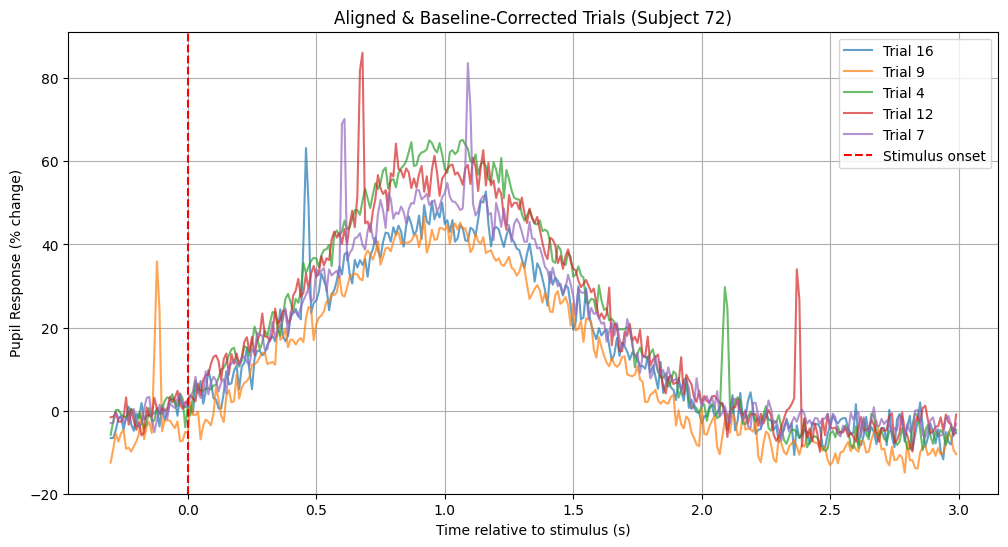

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Parameters
analysis_window = (-0.3, 3.0)  # seconds relative to onset
baseline_window = (-0.2, 0.0)  # pre-stimulus baseline
fs = 100

def align_and_preprocess_trial(trial_df, fs=100, window=(-0.2, 3.0), baseline=(-0.2, 0.0)):
    """
    Align a single trial to stimulus onset, resample, baseline-correct.
    """
    # Find stimulus onset time
    stim_onset = trial_df.loc[trial_df['stimulus'] == "stimulus", 'time'].min()
    if pd.isna(stim_onset):
        return None

    # Shift time so onset = 0
    trial_df = trial_df.copy()
    trial_df['time_rel'] = trial_df['time'] - stim_onset

    # Select window around onset
    mask = (trial_df['time_rel'] >= window[0]) & (trial_df['time_rel'] <= window[1])
    trial_df = trial_df.loc[mask]
    if trial_df.empty:
        return None

    # New uniform time axis
    new_time = np.arange(window[0], window[1], 1/fs)

    # Interpolation to resample
    interp = np.interp(new_time, trial_df['time_rel'], trial_df['pupil_diameter'])

    # Baseline correction (% signal change)
    baseline_mask = (new_time >= baseline[0]) & (new_time <= baseline[1])
    baseline_val = np.mean(interp[baseline_mask])
    interp_norm = ((interp - baseline_val) / baseline_val) * 100

    return new_time, interp_norm

# Pick 5 random trials from subject_72
subject_id = 72
trial_ids = df['trialID'].unique()
selected_trials = np.random.choice(trial_ids, 5, replace=False)

plt.figure(figsize=(12,6))
for trial in selected_trials:
    trial_df = df[df['trialID'] == trial]
    aligned = align_and_preprocess_trial(trial_df, fs=fs,
                                         window=analysis_window,
                                         baseline=baseline_window)
    if aligned:
        t, y = aligned
        plt.plot(t, y, alpha=0.7, label=f"Trial {trial}")

plt.axvline(0, color="red", linestyle="--", label="Stimulus onset")
plt.title(f"Aligned & Baseline-Corrected Trials (Subject {subject_id})")
plt.xlabel("Time relative to stimulus (s)")
plt.ylabel("Pupil Response (% change)")
plt.legend()
plt.grid(True)
plt.show()


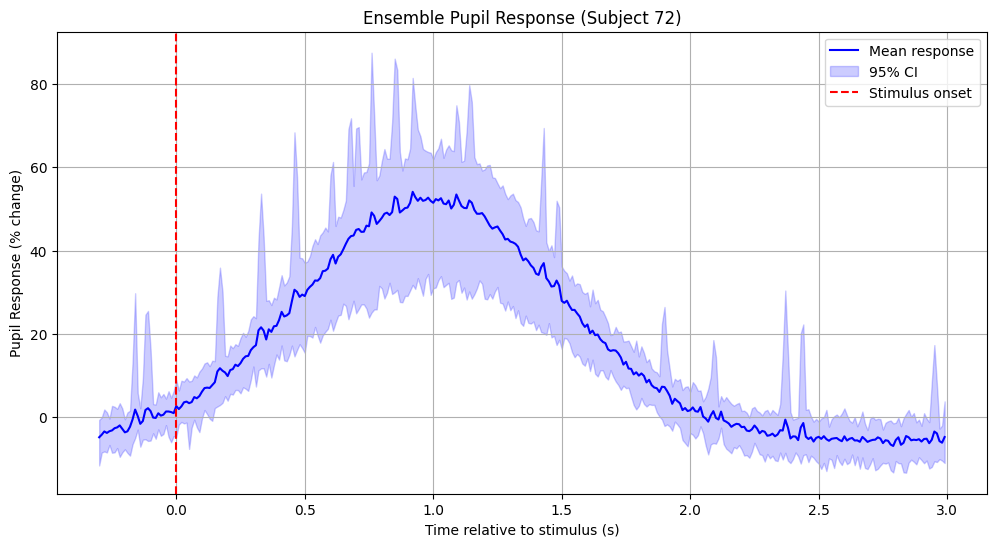

In [10]:
all_trials = []
for trial in trial_ids:
    trial_df = df[df['trialID'] == trial]
    aligned = align_and_preprocess_trial(trial_df, fs=fs,
                                         window=analysis_window,
                                         baseline=baseline_window)
    if aligned:
        t, y = aligned
        all_trials.append(y)

all_trials = np.array(all_trials)
mean_response = np.nanmean(all_trials, axis=0)
ci_low = np.percentile(all_trials, 2.5, axis=0)
ci_high = np.percentile(all_trials, 97.5, axis=0)

# Plot ensemble
plt.figure(figsize=(12,6))
plt.plot(t, mean_response, color="blue", label="Mean response")
plt.fill_between(t, ci_low, ci_high, color="blue", alpha=0.2, label="95% CI")
plt.axvline(0, color="red", linestyle="--", label="Stimulus onset")
plt.title(f"Ensemble Pupil Response (Subject {subject_id})")
plt.xlabel("Time relative to stimulus (s)")
plt.ylabel("Pupil Response (% change)")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
import os
import glob

# Adjust to your dataset folder in Drive
data_folder = "/content/drive/MyDrive/Braingaze_dataset"

subject_summaries = []

for filepath in glob.glob(os.path.join(data_folder, "subject_*.csv")):
    subject_id = int(os.path.basename(filepath).split("_")[1].split(".")[0])

    df_sub = pd.read_csv(filepath)
    trial_ids = df_sub['trialID'].unique()

    subject_trials = []

    for trial in trial_ids:
        trial_df = df_sub[df_sub['trialID'] == trial]
        aligned = align_and_preprocess_trial(trial_df, fs=fs,
                                             window=analysis_window,
                                             baseline=baseline_window)
        if aligned:
            _, y = aligned
            subject_trials.append(y)

    if len(subject_trials) == 0:
        continue

    subject_trials = np.array(subject_trials)
    mean_response = np.nanmean(subject_trials, axis=0)

    # Extract simple features
    peak_amp = np.max(mean_response)             # max dilation
    latency = t[np.argmax(mean_response)]        # latency to peak

    subject_summaries.append({
        "subject_id": subject_id,
        "n_trials": len(trial_ids),
        "n_valid_trials": len(subject_trials),
        "mean_peak_amp": peak_amp,
        "mean_latency": latency
    })



# Save summary table
summary_df = pd.DataFrame(subject_summaries)
summary_path = "/content/drive/MyDrive/Braingaze_dataset/summery/subject_summary.csv"
summary_df.to_csv(summary_path, index=False)
print("Summary saved to:", summary_path)
summary_df.head()


Summary saved to: /content/drive/MyDrive/Braingaze_dataset/subject_summary.csv


,subject_id,n_trials,n_valid_trials,mean_peak_amp,mean_latency
0,24,21,21,44.020889,0.95
1,2,19,19,25.707922,0.82
2,18,20,20,38.382582,0.96
3,15,17,17,29.403518,0.87
4,3,20,20,31.478550,0.98


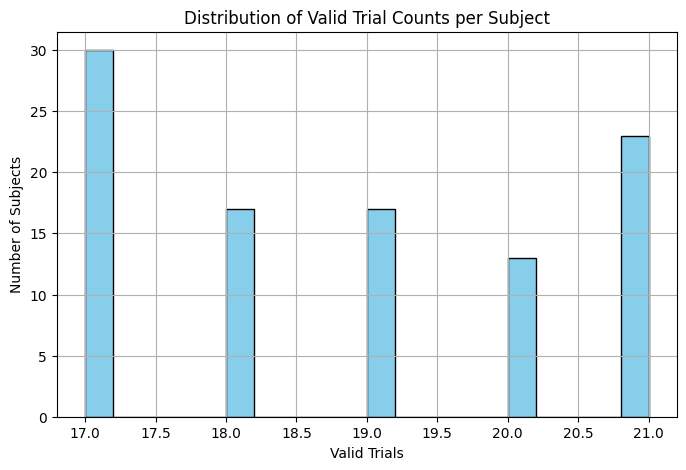

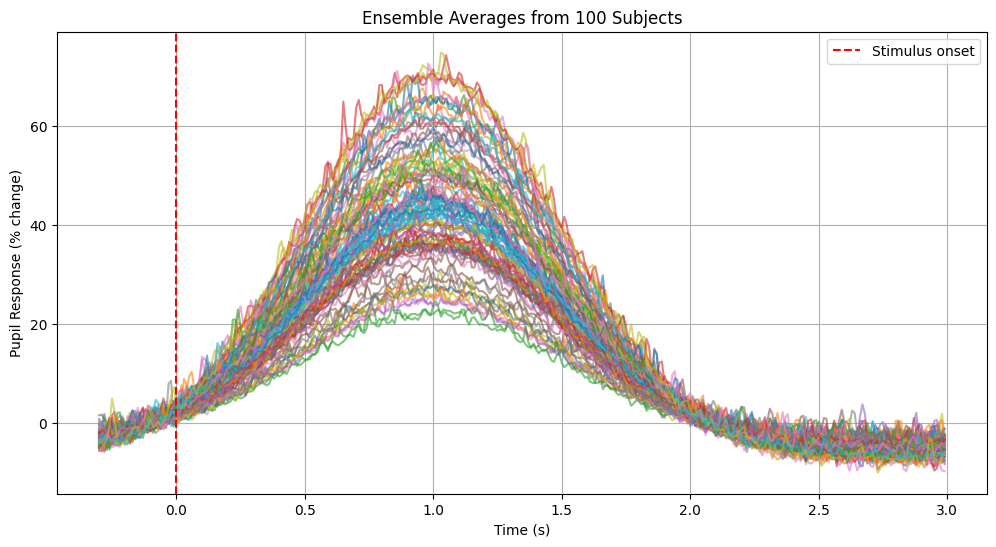

In [12]:
# Histogram of valid trials per subject
plt.figure(figsize=(8,5))
plt.hist(summary_df['n_valid_trials'], bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of Valid Trial Counts per Subject")
plt.xlabel("Valid Trials")
plt.ylabel("Number of Subjects")
plt.grid(True)
plt.show()

# Overlay random 10 subject ensemble averages
plt.figure(figsize=(12,6))
sampled_subjects = summary_df.sample(100, random_state=42)['subject_id']
for subj in sampled_subjects:
    filepath = os.path.join(data_folder, f"subject_{subj}.csv")
    df_sub = pd.read_csv(filepath)

    trial_ids = df_sub['trialID'].unique()
    subj_trials = []
    for trial in trial_ids:
        aligned = align_and_preprocess_trial(df_sub[df_sub['trialID']==trial], fs=fs,
                                             window=analysis_window,
                                             baseline=baseline_window)
        if aligned:
            _, y = aligned
            subj_trials.append(y)

    if subj_trials:
        subj_trials = np.array(subj_trials)
        mean_resp = np.nanmean(subj_trials, axis=0)
        plt.plot(t, mean_resp, alpha=0.6)

plt.axvline(0, color="red", linestyle="--", label="Stimulus onset")
plt.title("Ensemble Averages from 100 Subjects")
plt.xlabel("Time (s)")
plt.ylabel("Pupil Response (% change)")
plt.grid(True)
plt.legend()
plt.show()


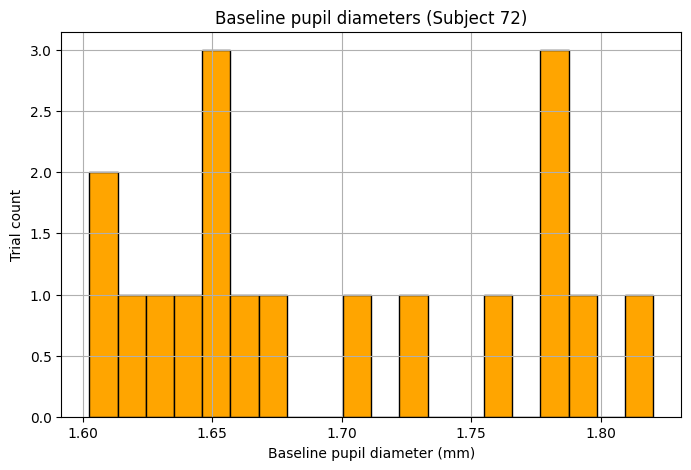

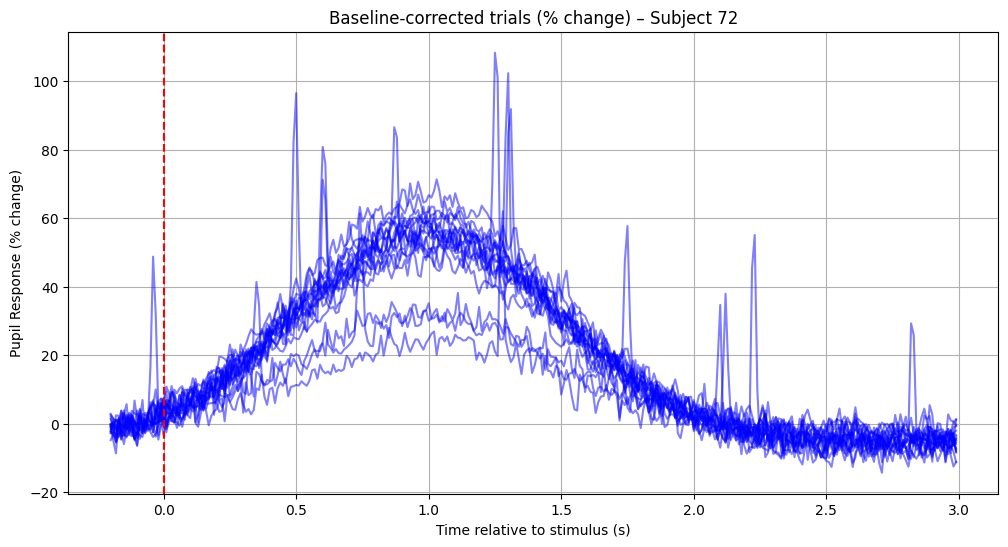

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob, os

# Parameters
analysis_window = (-0.2, 3.0)  # s relative to stimulus
baseline_window = (-0.2, 0.0)
fs = 100

def compute_baseline(trial_df, fs=100, window=(-0.2, 3.0), baseline=(-0.2, 0.0)):
    """
    Aligns a trial, computes baseline (robust median), and applies % signal change normalization.
    Returns (time, corrected_signal, baseline_value).
    """
    stim_onset = trial_df.loc[trial_df['stimulus']=="stimulus", 'time'].min()
    if pd.isna(stim_onset):
        return None

    trial_df = trial_df.copy()
    trial_df['time_rel'] = trial_df['time'] - stim_onset
    mask = (trial_df['time_rel'] >= window[0]) & (trial_df['time_rel'] <= window[1])
    trial_df = trial_df.loc[mask]
    if trial_df.empty:
        return None

    new_time = np.arange(window[0], window[1], 1/fs)
    interp = np.interp(new_time, trial_df['time_rel'], trial_df['pupil_diameter'])

    baseline_mask = (new_time >= baseline[0]) & (new_time <= baseline[1])
    baseline_val = np.median(interp[baseline_mask])

    corrected = ((interp - baseline_val) / baseline_val) * 100

    return new_time, corrected, baseline_val

# Example: Baseline distribution for one subject
subject_id = 72
file_path = f"/content/drive/MyDrive/Braingaze_dataset/subject_{subject_id}.csv"
df_sub = pd.read_csv(file_path)

baseline_vals = []
corrected_trials = []

for trial in df_sub['trialID'].unique():
    trial_df = df_sub[df_sub['trialID']==trial]
    result = compute_baseline(trial_df, fs=fs,
                              window=analysis_window,
                              baseline=baseline_window)
    if result:
        t, y, b = result
        baseline_vals.append(b)
        corrected_trials.append(y)

# Plot histogram of baseline values
plt.figure(figsize=(8,5))
plt.hist(baseline_vals, bins=20, color="orange", edgecolor="black")
plt.title(f"Baseline pupil diameters (Subject {subject_id})")
plt.xlabel("Baseline pupil diameter (mm)")
plt.ylabel("Trial count")
plt.grid(True)
plt.show()

# Check that corrected signals have ~0% baseline
plt.figure(figsize=(12,6))
for y in corrected_trials:
    plt.plot(t, y, alpha=0.5, color="blue")
plt.axvline(0, color="red", linestyle="--", label="Stimulus onset")
plt.title(f"Baseline-corrected trials (% change) – Subject {subject_id}")
plt.xlabel("Time relative to stimulus (s)")
plt.ylabel("Pupil Response (% change)")
plt.grid(True)
plt.show()


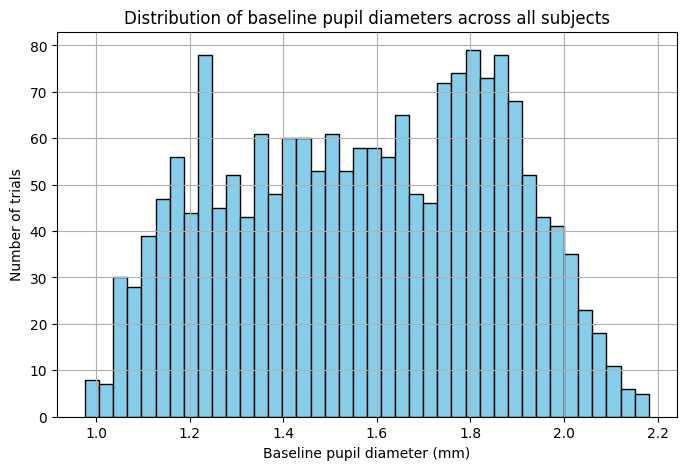

In [21]:
all_baselines = []

data_folder = "/content/drive/MyDrive/Braingaze_dataset"

for filepath in glob.glob(os.path.join(data_folder, "subject_*.csv")):
    # Read the subject's data file
    df_sub_data = pd.read_csv(filepath)
    for trial in df_sub_data['trialID'].unique():
        result = compute_baseline(df_sub_data[df_sub_data['trialID']==trial],
                                  fs=fs,
                                  window=analysis_window,
                                  baseline=baseline_window)
        if result:
            _, _, b = result
            all_baselines.append(b)

plt.figure(figsize=(8,5))
plt.hist(all_baselines, bins=40, color="skyblue", edgecolor="black")
plt.title("Distribution of baseline pupil diameters across all subjects")
plt.xlabel("Baseline pupil diameter (mm)")
plt.ylabel("Number of trials")
plt.grid(True)
plt.show()

In [22]:
import numpy as np
import pandas as pd

def extract_features_from_trial(t, y, blink_mask=None, baseline_window=(-0.2, 0.0), response_window=(0, 3.0)):
    """
    Extract core features from one baseline-corrected, aligned trial.
    Parameters
    ----------
    t : array-like
        Time vector (s, relative to stimulus onset), should include pre-stimulus.
    y : array-like
        Pupil response (% change, baseline corrected).
    blink_mask : array-like or None
        Boolean mask of blink-affected samples (True=blink).
    baseline_window : tuple
        Time window for baseline noise calculation.
    response_window : tuple
        Time window for feature extraction.
    Returns
    -------
    dict of features
    """
    t = np.asarray(t)
    y = np.asarray(y)

    if len(t) < 5 or np.all(np.isnan(y)):
        return None

    # Baseline noise (pre-stimulus)
    base_mask = (t >= baseline_window[0]) & (t <= baseline_window[1])
    if np.any(base_mask):
        noise_std = np.nanstd(y[base_mask])
    else:
        noise_std = np.nanstd(y[:int(0.2/np.median(np.diff(t)))])  # fallback
    noise_std = noise_std if noise_std > 0 else 1e-6


    # Restrict to response window (post-stimulus)
    resp_mask = (t >= response_window[0]) & (t <= response_window[1])
    t_resp = t[resp_mask]
    y_resp = y[resp_mask]
    if len(t_resp) == 0:
        return None

    # Peak amplitude & latency
    peak_idx = np.nanargmax(y_resp)
    peak_amp = y_resp[peak_idx]
    peak_time = t_resp[peak_idx]


    # Rise slope (10-90% method)
    rise_slope = np.nan
    try:
        y_norm = (y_resp - np.min(y_resp)) / (peak_amp - np.min(y_resp) + 1e-6)
        t10 = t_resp[np.where(y_norm >= 0.1)[0][0]]
        t90 = t_resp[np.where(y_norm >= 0.9)[0][0]]
        rise_slope = (0.8 * peak_amp) / (t90 - t10 + 1e-6)
    except Exception:
        pass


    # Decay slope
    decay_window = (t_resp >= (response_window[1] - 0.5))
    if np.any(decay_window) and peak_time < response_window[1] - 0.5:
        decay_slope = (np.nanmean(y_resp[decay_window]) - peak_amp) / (
            (response_window[1] - 0.5) - peak_time + 1e-6
        )
    else:
        decay_slope = np.nan


    # Area under curve (AUC)
    auc = np.trapz(y_resp, t_resp)


    # Trial SNR
    trial_snr = peak_amp / noise_std


    # Missing data / blinks
    if blink_mask is not None and len(blink_mask) == len(t):
        pct_missing = np.mean(blink_mask[resp_mask]) * 100
    else:
        pct_missing = 0

    return {
        "peak_amp": peak_amp,
        "peak_time": peak_time,
        "rise_slope": rise_slope,
        "decay_slope": decay_slope,
        "AUC": auc,
        "trial_SNR": trial_snr,
        "pct_missing": pct_missing,
    }


In [23]:
def process_subject(filepath, fs=100, window=(-0.2, 3.0), baseline=(-0.2, 0.0)):
    """
    Process all trials for a subject and return trial-level + subject-level features.
    """
    df = pd.read_csv(filepath)
    subject_id = int(os.path.basename(filepath).split("_")[1].split(".")[0])

    trial_features = []
    for trial_id in df['trialID'].unique():
        trial_df = df[df['trialID'] == trial_id]

        # Re-use baseline alignment function from Step 5
        result = compute_baseline(trial_df, fs=fs, window=window, baseline=baseline)
        if result:
            t, y, baseline_val = result
            feat = extract_features_from_trial(t, y, blink_mask=None,
                                               baseline_window=baseline,
                                               response_window=(0, window[1]))
            if feat:
                feat["subject_id"] = subject_id
                feat["trial_id"] = trial_id
                trial_features.append(feat)

    if not trial_features:
        return None, None

    trial_df_out = pd.DataFrame(trial_features)

    # Subject-level aggregation
    subject_summary = {
        "subject_id": subject_id,
        "n_trials": trial_df_out.shape[0],
        "mean_peak_amp": trial_df_out["peak_amp"].mean(),
        "sd_peak_amp": trial_df_out["peak_amp"].std(),
        "cv_peak_amp": trial_df_out["peak_amp"].std() / (trial_df_out["peak_amp"].mean() + 1e-6),
        "mean_latency": trial_df_out["peak_time"].mean(),
        "sd_latency": trial_df_out["peak_time"].std(),
        "cv_latency": trial_df_out["peak_time"].std() / (trial_df_out["peak_time"].mean() + 1e-6),
        "mean_AUC": trial_df_out["AUC"].mean(),
        "mean_SNR": trial_df_out["trial_SNR"].mean(),
        "mean_rise_slope": trial_df_out["rise_slope"].mean(),
        "mean_decay_slope": trial_df_out["decay_slope"].mean(),
    }

    return trial_df_out, subject_summary


In [24]:
import glob, os

data_folder = "/content/drive/MyDrive/Braingaze_dataset"

all_trials = []
all_subjects = []

for filepath in glob.glob(os.path.join(data_folder, "subject_*.csv")):
    trial_feats, subj_summary = process_subject(filepath)
    if trial_feats is not None:
        all_trials.append(trial_feats)
        all_subjects.append(subj_summary)

# Save trial-level features
trials_df = pd.concat(all_trials, ignore_index=True)
trials_df.to_csv(os.path.join(data_folder, "trial_features.csv"), index=False)

# Save subject summaries
subjects_df = pd.DataFrame(all_subjects)
subjects_df.to_csv(os.path.join(data_folder, "subject_summary.csv"), index=False)

print("Saved trial_features.csv and subject_summary.csv")


/tmp/ipython-input-4140893694.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y_resp, t_resp)
/tmp/ipython-input-4140893694.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y_resp, t_resp)
/tmp/ipython-input-4140893694.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y_resp, t_resp)
/tmp/ipython-input-4140893694.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y_resp, t_resp)
/tmp/ipython-input-4140893694.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  a

Saved trial_features.csv and subject_summary.csv


/tmp/ipython-input-4140893694.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y_resp, t_resp)
/tmp/ipython-input-4140893694.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y_resp, t_resp)
/tmp/ipython-input-4140893694.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y_resp, t_resp)
/tmp/ipython-input-4140893694.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y_resp, t_resp)
/tmp/ipython-input-4140893694.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  a

/tmp/ipython-input-4140893694.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y_resp, t_resp)


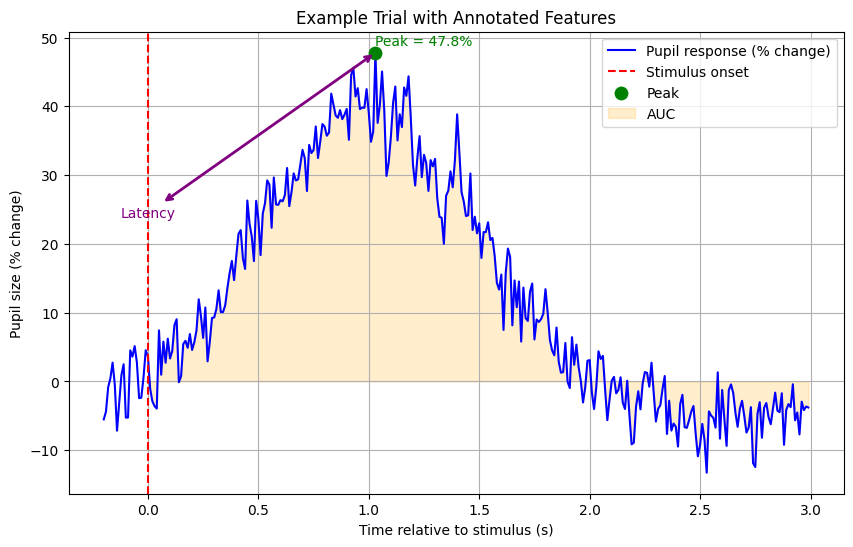

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trial_with_features(t, y, features, response_window=(0, 3.0)):
    """
    Plot one trial with annotated features:
    - Stimulus onset
    - Peak amplitude
    - Latency
    - Shaded AUC
    """
    plt.figure(figsize=(10,6))

    # Plot trial curve
    plt.plot(t, y, label="Pupil response (% change)", color="blue")

    # Stimulus onset
    plt.axvline(0, color="red", linestyle="--", label="Stimulus onset")

    # Peak point
    peak_time = features["peak_time"]
    peak_amp = features["peak_amp"]
    plt.scatter(peak_time, peak_amp, color="green", s=80, zorder=3, label="Peak")
    plt.text(peak_time, peak_amp+1, f"Peak = {peak_amp:.1f}%", color="green")

    # Latency arrow (0 → peak)
    plt.annotate("Latency",
                 xy=(peak_time, peak_amp), xycoords='data',
                 xytext=(0, peak_amp/2), textcoords='data',
                 arrowprops=dict(arrowstyle="<->", color="purple", lw=2),
                 ha="center", color="purple")

    # Shade AUC
    auc_mask = (t >= response_window[0]) & (t <= response_window[1])
    plt.fill_between(t[auc_mask], y[auc_mask], alpha=0.2, color="orange", label="AUC")

    # Labels & formatting
    plt.title("Example Trial with Annotated Features")
    plt.xlabel("Time relative to stimulus (s)")
    plt.ylabel("Pupil size (% change)")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Example usage (assuming you have a corrected trial and its features)
# Take one trial from trials_df (Step 6 output)
example_trial = trials_df.iloc[0]

# Get subject & trial IDs
sub_id = int(example_trial["subject_id"])  # Convert to integer
trial_id = example_trial["trial_id"]

# Re-load this trial’s time & signal using Step 5 baseline function
df_sub = pd.read_csv(f"/content/drive/MyDrive/Braingaze_dataset/subject_{sub_id}.csv")
trial_df = df_sub[df_sub['trialID'] == trial_id]
t, y, _ = compute_baseline(trial_df, fs=100, window=(-0.2, 3.0), baseline=(-0.2, 0.0))

# Extract features for this trial
feat = extract_features_from_trial(t, y)

# Plot annotated trial
plot_trial_with_features(t, y, feat)

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, recall_score, balanced_accuracy_score, roc_auc_score


# 1. Load features & labels

features_path = "/content/drive/MyDrive/Braingaze_dataset/subject_summary.csv"
labels_path = "/content/drive/MyDrive/Braingaze_dataset/metadata/metadata.csv"

features = pd.read_csv(features_path)
labels = pd.read_csv(labels_path)

# Ensure column naming consistency
labels.rename(columns={"subjectID": "subject_id", "class": "label"}, inplace=True)

# Merge features with labels
data = pd.merge(features, labels, on="subject_id")
X = data.drop(columns=["subject_id", "label"])
y = data["label"].map({"Patient": 1, "Healthy": 0})  # 1 = Patient, 0 = Healthy

print("Feature matrix shape:", X.shape)
print("Class distribution:\n", y.value_counts())


# 2. Define pipeline

# Standardize features + Logistic Regression
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])


# 3. Define metrics

scoring = {
    "sensitivity": make_scorer(recall_score, pos_label=1),  # Patient recall
    "specificity": make_scorer(recall_score, pos_label=0),  # Healthy recall
    "balanced_acc": make_scorer(balanced_accuracy_score),
    "roc_auc": "roc_auc"
}


# 4. Stratified CV Evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, return_train_score=False)


# 5. Print results
print("\n=== Cross-Validation Results ===")
for metric in scoring.keys():
    mean_score = np.mean(cv_results[f"test_{metric}"])
    std_score = np.std(cv_results[f"test_{metric}"])
    print(f"{metric}: {mean_score:.3f} ± {std_score:.3f}")


Feature matrix shape: (100, 11)
Class distribution:
 label
0    68
1    32
Name: count, dtype: int64

=== Cross-Validation Results ===
sensitivity: 0.881 ± 0.109
specificity: 0.955 ± 0.061
balanced_acc: 0.918 ± 0.075
roc_auc: 0.976 ± 0.043


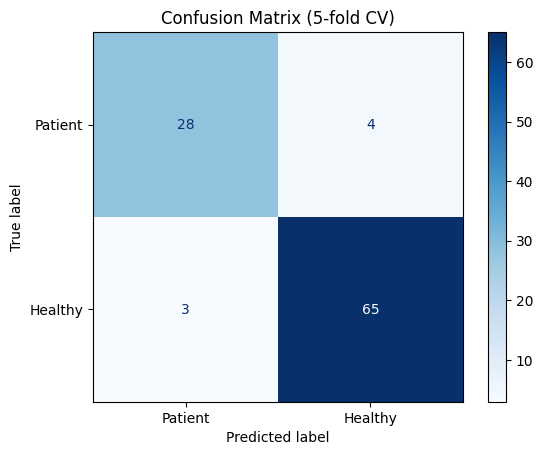

In [30]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate cross-validated predictions
y_pred = cross_val_predict(pipeline, X, y, cv=cv)

# Confusion matrix
cm = confusion_matrix(y, y_pred, labels=[1,0])  # [Patient, Healthy]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Patient", "Healthy"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (5-fold CV)")
plt.show()


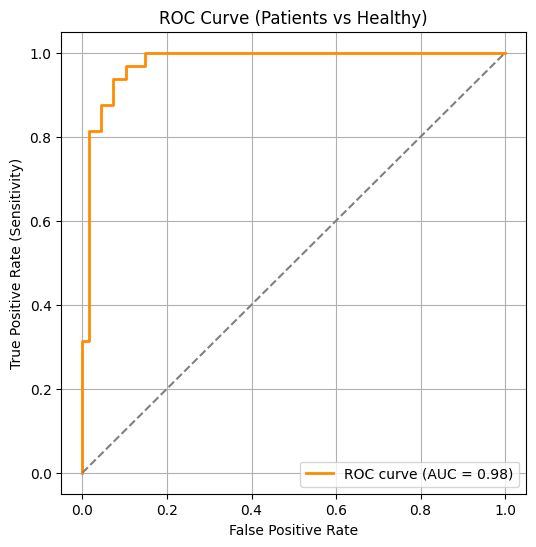

In [31]:
from sklearn.metrics import roc_curve, auc

# Get cross-validated predicted probabilities
y_prob = cross_val_predict(pipeline, X, y, cv=cv, method="predict_proba")[:,1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve (Patients vs Healthy)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


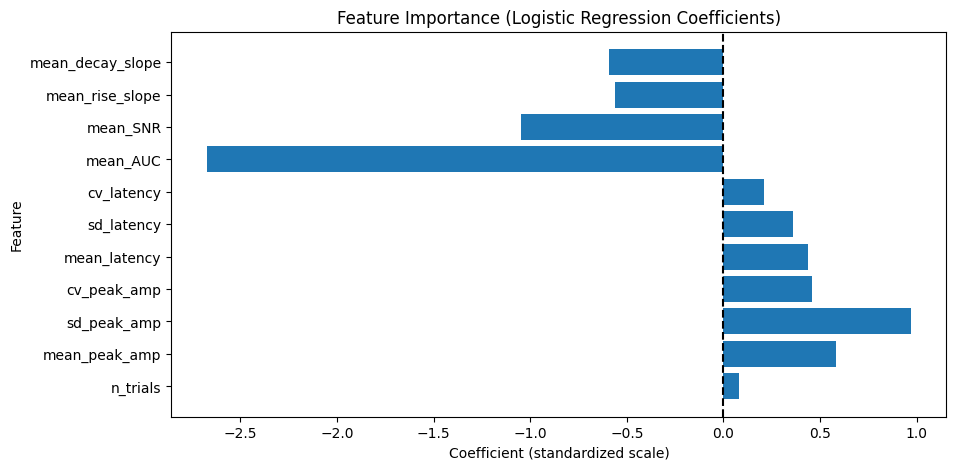

In [32]:
# Refit on all data to inspect coefficients
pipeline.fit(X, y)
clf = pipeline.named_steps["clf"]
scaler = pipeline.named_steps["scaler"]

# Get feature names
feature_names = X.columns

# Coefficients (scaled)
coefs = clf.coef_[0]

# Plot
plt.figure(figsize=(10,5))
plt.barh(feature_names, coefs)
plt.axvline(0, color="black", linestyle="--")
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Coefficient (standardized scale)")
plt.ylabel("Feature")
plt.show()
